In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

#Read the data from csv into dataframe
LGA_INFO = pd.read_csv('Data/LGA_2016_VIC.csv')
LGA_SPORT_FACILITY = pd.read_csv('Data/Victoria_Sport_and_Recreation_Facility_Location.csv')
LGA_HEALTH_RISK = pd.read_csv('Data/LGA_Adults_Health Risk_Factor_Estimates.csv')

#Cleaning area name and corresponding area code, and make a dictionary
LGA_NAME_TO_CODE = LGA_INFO[['LGA_CODE_2016', 'LGA_NAME_2016']]
LGA_NAME_TO_CODE = LGA_NAME_TO_CODE.drop_duplicates()
LGA_NAME_TO_CODE['LGA_NAME_2016'] = LGA_NAME_TO_CODE['LGA_NAME_2016'].str.replace(r' \([^()]*\)', '', regex=True)
LGA_NAME_TO_CODE['LGA_NAME_2016'] = LGA_NAME_TO_CODE['LGA_NAME_2016'].str.upper()
LGA_DIC = LGA_NAME_TO_CODE.set_index('LGA_NAME_2016')['LGA_CODE_2016'].to_dict()

#Find the corresponding area codes for the sport facilities
area_code = LGA_SPORT_FACILITY['lga'].to_list()
for i in range(len(area_code)):
    if area_code[i] in LGA_DIC:
        area_code[i] = LGA_DIC[area_code[i]]
    else:
        area_code[i] = None

#Print the area names that does not have a corresponding code
# for i in range(len(area_code)):
#     if area_code[i] == None:
#         print(LGA_SPORT_FACILITY['lga'].to_list()[i])

#Add the area codes and clean the sport facility dataframe
LGA_SPORT_FACILITY['lga_code'] = area_code
LGA_SPORT_FACILITY = LGA_SPORT_FACILITY.dropna(subset=['lga_code'])
LGA_SPORT_FACILITY['lga_code'] = LGA_SPORT_FACILITY['lga_code'].astype(dtype='int')

#Group the sport facilities by area code
FACILITY_COUNT_PER_LGA = LGA_SPORT_FACILITY.groupby('lga_code', as_index=False).count()[['lga_code', 'lga']]
#print(FACILITY_COUNT_PER_LGA)

#Join the sport facility dataframe and health risk dataframe together by lga
JOINED = FACILITY_COUNT_PER_LGA.set_index('lga_code').join(LGA_HEALTH_RISK.set_index('lga_code'), on='lga_code', how='left', sort=False)
# print(JOINED)

# plot1 = JOINED.plot.scatter(x='lga', y='lw_excse_4_asr_uci', c='Blue')
# plot2 = JOINED.plot.scatter(x='lga', y='hbld_pres_2_asr', c='Red')
# plot3 = JOINED.plot.scatter(x='lga', y='ovrwgt_p_2_asr', c='Orange')
# plot4 = JOINED.plot.scatter(x='lga', y='obese_p_2_asr', c='Green')

#Read region population csv
region_population = pd.read_csv('Data/regional_population_csv.csv')

#Join region_population dataframe and JOINED together by lga code
JOINED_2 = JOINED.join(region_population.set_index('lga_code'), on='lga_code', how='left', sort=False)
JOINED_2['num_facility_per_capita(2016)']=JOINED_2['lga']/JOINED_2['population2016']
JOINED_2['num_facility_per_capita(2017)']=JOINED_2['lga']/JOINED_2['population2017']
JOINED_2['num_facility_per_km2']=JOINED_2['lga']/JOINED_2['Area(km2)']

In [113]:
LGA_SPORT_FACILITY['total'] = LGA_SPORT_FACILITY.groupby('lga_code')['lga_code'].transform('count')

GROUPBY_LGA_AND_SPORT = LGA_SPORT_FACILITY.groupby(['lga_code','sportsplayed', 'total']).size().reset_index(name='count')
GROUPBY_LGA_AND_SPORT = GROUPBY_LGA_AND_SPORT.set_index('lga_code').join(LGA_HEALTH_RISK.set_index('lga_code'), on='lga_code', how='left', sort=False)
GROUPBY_LGA_AND_SPORT['percentage'] = GROUPBY_LGA_AND_SPORT['count'] / GROUPBY_LGA_AND_SPORT['total']
TOP = GROUPBY_LGA_AND_SPORT.sort_values(['lw_excse_4_asr_uci', 'lga_code', 'percentage'], ascending=[True, True, False]).groupby('lga_code').head(2)
pd.set_option('display.max_rows', 20)
TOP

,sportsplayed,total,count,lw_excse_4_asr_uci,hbld_pres_2_asr,ovrwgt_p_2_asr,obese_p_2_asr,percentage
lga_code,,,,,,,,
25900,Cricket,76,11,57.9,31.9,36.6,17.4,0.144737
25900,Tennis (Outdoor),76,8,57.9,31.9,36.6,17.4,0.105263
26350,Cricket,114,21,57.9,24.7,37.4,15.5,0.184211
26350,Fitness / Gymnasium Workouts,114,20,57.9,24.7,37.4,15.5,0.175439
21110,Cricket,186,44,58.6,19.3,38.6,14.5,0.236559
...,...,...,...,...,...,...,...,...
25620,Tennis (Outdoor),68,9,77.0,21.3,37.0,32.7,0.132353
26170,Tennis (Outdoor),30,5,78.8,27.6,36.1,31.2,0.166667
26170,Cricket,30,4,78.8,27.6,36.1,31.2,0.133333


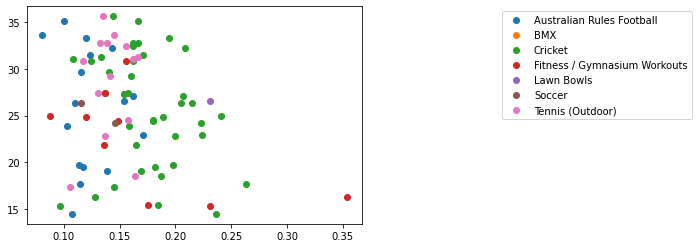

In [115]:
groups = TOP.groupby("sportsplayed")
for name, group in groups:
    plt.plot(group["percentage"], group["obese_p_2_asr"], marker="o", linestyle="", label=name)
plt.legend(bbox_to_anchor=(2, 1), loc='upper right')